# WGAN-autoencoder (after optimization)
We use the adversarial autoencoder (https://arxiv.org/pdf/1511.05644.pdf) to encode data, the Wasserstein-GAN (https://arxiv.org/pdf/1704.00028v3.pdf) works in the new (encoded) space.
The generator model generates samples from latent space to the encoded space, the discriminator model distinguishes real and fake samples in the encoded space. The decoding is used after generation in order to represent samples from the encoded space to the initial space.

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.utils import shuffle
import matplotlib
import torch.autograd as autograd
import random
import torch.autograd as autograd
import sklearn.metrics
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

import pickle
import torch.autograd as autograd
from sklearn.preprocessing import StandardScaler

random_seed = 1245627304
torch.manual_seed(random_seed)
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else "cpu")

In [3]:
params = pickle.load(open('wgan_best_parameters.pkl', 'rb'))
# print(params)
params_model = pickle.load(open('wgan_best_model_parameters.pkl', 'rb'))
# print(params_model)
params.update(params_model)
print(params)

{'lr_auto': 0.006435632456005054, 'epochs_autoen': 87, 'lr_wgan': 0.0028886418155533253, 'iters': 1031, 'critic_iters': 8, 'lambda': 6, 'emb_dim': 321, 'random_dim': 22}


In [4]:
batch_size = 128
lr_wgan = params.get('lr_wgan')
lr_auto = params.get('lr_auto')
seq_len = 5000 # initial space
emb_dim = params.get('emb_dim') # encoded space
random_dim = params.get('random_dim')  # latent space for the generator model
epochs_autoen = params.get('epochs_autoen') #epochs to train autoencoder
ITERS = params.get('iters') # iterations to train WGAN
CRITIC_ITERS = params.get('critic_iters')
LAMBDA = params.get('lambda') # penalty

## 1. Preprocessing

In [3]:
pulses = pickle.load(open('/Users/nzaretski/Desktop/gerda/CNN_GAN_Ge/data/raw/data.pkl','rb'))
pulses = pulses.astype(float)

In [4]:
scaler = StandardScaler()
pulses = scaler.fit_transform(pulses)

pickle.dump(scaler, open('scaler.pkl','wb'))

In [5]:
train_data_length = pulses.shape[0]
train_data = torch.zeros((train_data_length, 3748))
train_data = torch.tensor(pulses, dtype=torch.float)
train_labels = torch.zeros(train_data_length, 1)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

## 1. Models

In [5]:
class Encoder(nn.Module):
    def __init__(self, seq_len, emb_dim):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 2, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 8, self.emb_dim, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)
    
class Decoder(nn.Module):
    def __init__(self, seq_len, emb_dim):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.emb_dim, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 8, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False),
      )
    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

In [6]:
class Discriminator(nn.Module):   
    def __init__(self, emb_dim):
        super(Discriminator, self).__init__()
        self.emb_dim = emb_dim
        self.model = nn.Sequential(            
            nn.Conv1d(self.emb_dim, self.emb_dim // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 2, self.emb_dim // 4, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 4, self.emb_dim // 8, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(self.emb_dim // 8, self.emb_dim // 16, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 16, 1, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)
    
class Generator(nn.Module):
    def __init__(self, emb_dim, random_dim):
        super(Generator, self).__init__()
        self.emb_dim = emb_dim
        self.random_dim = random_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.random_dim, self.emb_dim // 8, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.emb_dim // 8, self.emb_dim // 4, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.emb_dim // 4, self.emb_dim // 2, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.emb_dim // 2, self.emb_dim, 1, bias=False),
      )
    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

In [7]:
class PriorDiscriminator(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.l0 = nn.Linear(self.emb_dim, 64)
        self.l1 = nn.Linear(64, 64//4)
        self.l2 = nn.Linear(64//4, 1)
        
    def forward(self, x):
        h = F.leaky_relu(self.l0(x))
        h = F.leaky_relu(self.l1(h))
        return torch.sigmoid(self.l2(h))

# Autoencoder

In [13]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(DEVICE)

mps


In [8]:
encoder = Encoder(seq_len, emb_dim).to(DEVICE)
decoder = Decoder(seq_len, emb_dim).to(DEVICE)
disc = PriorDiscriminator(emb_dim).to(DEVICE)
recon_loss = nn.MSELoss(reduction = 'sum').to(DEVICE)

In [16]:
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=lr_auto)
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=lr_auto)

optim_encoder_reg = torch.optim.Adam(encoder.parameters(), lr=lr_auto)
optim_D = torch.optim.Adam(disc.parameters(), lr=lr_auto)

In [17]:
loss_ep = []
losses = []
start_time = time.time()
one = torch.FloatTensor([1])
mone = one * -1
one = one.to(DEVICE)
mone = mone.to(DEVICE)
for epoch in range(epochs_autoen):
    for i, (x, y) in enumerate(train_loader):
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        batch = x.size(0)
        
        encoder.train()
        decoder.train()
        disc.train()
        
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()
        
        # Reconstruction phase
        z = encoder(x)
        x_hat = decoder(z)
        loss = recon_loss(x_hat,x)
        loss.backward()
        optim_encoder.step()
        optim_decoder.step()


        # Discriminator phase
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()
        encoder.eval()
        
        z_real_gauss = autograd.Variable(torch.randn(z.size())*1).to(DEVICE)
        z_fake_gauss = encoder(x)
        
        D_real_gauss, D_fake_gauss = disc(z_real_gauss), disc(z_fake_gauss.detach())
        
        real_outputs = D_real_gauss.mean(dim=0)
        real_outputs.backward(mone)
        fake_outputs = D_fake_gauss.mean(dim=0)
        fake_outputs.backward(one)
        optim_D.step()
        
        # Regularization phase
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()

        encoder.train()
        z = encoder(x)
        D_fake_gauss = disc(z)
        fake_outputs = D_fake_gauss.mean(dim=0)
        fake_outputs.backward(mone)
        optim_encoder_reg.step()
        
        if i % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(x), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))
            
        if (i == len(train_loader) - 1): # per epoch 
            loss_ep.append(loss.item())        
        
        losses.append(loss.item())        


    if epoch == 0:
        print("---1 epoch: %s seconds ---" % (time.time() - start_time))

Train Epoch: 0 [0/2619 (0%)]	Loss: 427437.343750
---1 epoch: 8.033674001693726 seconds ---
Train Epoch: 1 [0/2619 (0%)]	Loss: 171430.765625
Train Epoch: 2 [0/2619 (0%)]	Loss: 2132875.750000
Train Epoch: 3 [0/2619 (0%)]	Loss: 202331.500000
Train Epoch: 4 [0/2619 (0%)]	Loss: 103884.476562
Train Epoch: 5 [0/2619 (0%)]	Loss: 282021.218750
Train Epoch: 6 [0/2619 (0%)]	Loss: 361495.687500
Train Epoch: 7 [0/2619 (0%)]	Loss: 488485.031250
Train Epoch: 8 [0/2619 (0%)]	Loss: 66331.695312
Train Epoch: 9 [0/2619 (0%)]	Loss: 148345.375000
Train Epoch: 10 [0/2619 (0%)]	Loss: 548086.062500
Train Epoch: 11 [0/2619 (0%)]	Loss: 158014.078125
Train Epoch: 12 [0/2619 (0%)]	Loss: 300238.718750
Train Epoch: 13 [0/2619 (0%)]	Loss: 307312.687500
Train Epoch: 14 [0/2619 (0%)]	Loss: 113517.671875
Train Epoch: 15 [0/2619 (0%)]	Loss: 454444.468750
Train Epoch: 16 [0/2619 (0%)]	Loss: 115299.421875
Train Epoch: 17 [0/2619 (0%)]	Loss: 81145.851562
Train Epoch: 18 [0/2619 (0%)]	Loss: 90698.851562
Train Epoch: 19 [0/2

In [18]:
torch.save(decoder.state_dict(), 'wgan_auto_decoder.pth')

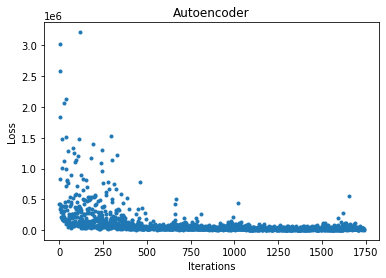

In [19]:
fig = plt.figure()
plt.plot(losses, '.')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Autoencoder")
fig.savefig('Auto_losses.png')

# WGAN

In [9]:
netD = Discriminator(emb_dim).to(DEVICE)
netG = Generator(emb_dim, random_dim).to(DEVICE)

In [24]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr_wgan)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_wgan)
loss_G=[]
loss_D=[]
epochs = []

one = torch.tensor(1, dtype=torch.float)
mone = one * -1
one = one.to(DEVICE)
mone = mone.to(DEVICE)

In [25]:
def inf_train_gen():
    while True:
        for images,targets in train_loader:
            yield images

In [26]:
def calc_gradient_penalty(netD, real_data, fake_data):
    #print real_data.size()
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(DEVICE)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = interpolates.to(DEVICE)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(DEVICE),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [27]:
netD = netD.to(DEVICE)
netG = netG.to(DEVICE)
data = inf_train_gen()
for iteration in range(ITERS):
    epochs.append(iteration)
    start_time = time.time()
    # (1) Update D network
    for p in netD.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in range(CRITIC_ITERS):
        _data = next(data)
        _data = _data.to(DEVICE)
        _data = encoder(_data).detach()
        real_data = torch.Tensor(_data)
        real_data = real_data.to(DEVICE)
        real_data_v = autograd.Variable(real_data).to(DEVICE)

        netD.zero_grad()

        # train with real
        D_real = netD(real_data_v)
        D_real = D_real.mean()
        # print D_real
        D_real.backward(mone)

        # train with fake
        noise = torch.randn(batch_size, random_dim).to(DEVICE)
        fake = netG(noise).detach()
        inputv = fake
        D_fake = netD(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optimizerD.step()
        
    loss_D.append(D_cost.item())
    # (2) Update G network
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
    netG.zero_grad()

    _data = next(data)
    noise = torch.randn(batch_size, random_dim).to(DEVICE)
    noisev = autograd.Variable(noise).to(DEVICE)
    fake = netG(noisev)
    G = netD(fake)
    G = G.mean()
    G.backward(mone)
    G_cost = -G
    loss_G.append(G_cost.item())
    optimizerG.step()
    if iteration % 50 == 0:
        print(G_cost.item(), D_cost.item())

0.3050795793533325 5.799543380737305
7.625192165374756 -4.119746685028076
49.70452880859375 -54.5384635925293
121.66658020019531 -137.93975830078125
88.55743408203125 -75.93413543701172
151.86105346679688 -106.42811584472656
151.6424560546875 -90.17493438720703
172.85299682617188 -143.80369567871094
166.62570190429688 -70.46868133544922
182.71058654785156 -108.62541198730469
232.8125457763672 -149.6697998046875
238.62570190429688 -196.14208984375
189.46617126464844 -25.288555145263672
205.79588317871094 -46.62886047363281
251.3271942138672 -110.8194351196289
201.5248260498047 -31.425399780273438
243.9015350341797 -94.63571166992188
160.48947143554688 -44.24003219604492
249.18804931640625 -27.352767944335938
430.2244873046875 -149.4158935546875
385.847900390625 -20.398658752441406


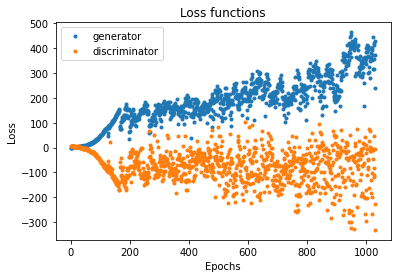

In [28]:
fig = plt.figure()
plt.plot(loss_G, '.', label='generator')
plt.plot(loss_D, '.',  label='discriminator')
plt.title('Loss functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
fig.savefig('losses.png')

In [29]:
torch.save(netG.state_dict(), 'wgan_auto.pth')

## Check

In [31]:
x = torch.randn(10, random_dim).to(DEVICE)

In [32]:
noise = netG(x)

In [33]:
a = decoder(noise).cpu().detach().numpy()

In [34]:
a = scaler.inverse_transform(a)

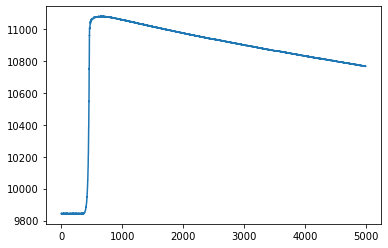

In [35]:
plt.plot(a[2])

In [36]:
a[0] - a[5]

array([-3.2285156, -1.5449219, -1.5664062, ..., 13.333984 ,  9.745117 ,
       10.894531 ], dtype=float32)